# Import Libraries

In [2]:
## Uncomment if you need to install the following packages
# !pip install seaborn
# !pip install scipy
# !pip install sklearn
# !pip install imblearn

In [3]:
import pandas as pd
from sqlite3 import connect
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, confusion_matrix, recall_score, accuracy_score, roc_auc_score, f1_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# Read in data

In [4]:
data = pd.read_csv('../data/ICU.csv').iloc[:, 1:] #remove the first column

In [5]:
data.head()

,ID,Survive,Age,AgeGroup,Sex,Infection,SysBP,Pulse,Emergency
0,4,0,87,3,1,1,80,96,1
1,8,1,27,1,1,1,142,88,1
2,12,1,59,2,0,0,112,80,1
3,14,1,77,3,0,0,100,70,0
4,27,0,76,3,1,1,128,90,1


# Clean data

- Null values
- Duplicated rows
- Column data types
- Outliers

In [6]:
# First we check for any null values. None so that is good. 
data.isnull().any()

ID           False
Survive      False
Age          False
AgeGroup     False
Sex          False
Infection    False
SysBP        False
Pulse        False
Emergency    False
dtype: bool

In [7]:
# Next, check for duplicated rows. None as well, and that is good too. 
print(f"Number of duplicated rows: {len(data[data.duplicated()])}")

Number of duplicated rows: 0


In [8]:
# Now we check for datatypes. 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         200 non-null    int64
 1   Survive    200 non-null    int64
 2   Age        200 non-null    int64
 3   AgeGroup   200 non-null    int64
 4   Sex        200 non-null    int64
 5   Infection  200 non-null    int64
 6   SysBP      200 non-null    int64
 7   Pulse      200 non-null    int64
 8   Emergency  200 non-null    int64
dtypes: int64(9)
memory usage: 14.2 KB


In [9]:
# We change the necessary columns to categorical variables. 
data[['Survive', 'AgeGroup', 'Sex', 'Infection', 'Emergency']] = data[['Survive', 'AgeGroup', 'Sex', 'Infection', 'Emergency']].astype('category') 

<AxesSubplot:ylabel='Frequency'>

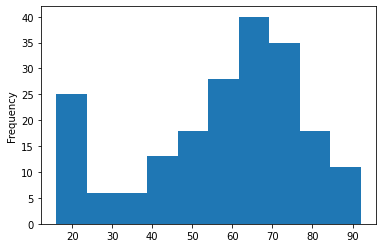

In [10]:
# Now, we check for outliers for each of the continuous variables by plotting a histogram. 
data.Age.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

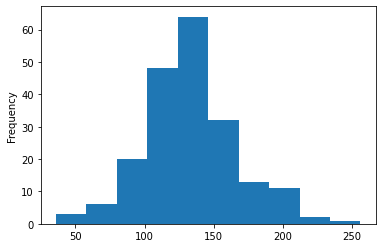

In [11]:
data.SysBP.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

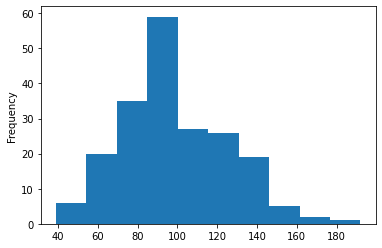

In [12]:
data.Pulse.plot(kind='hist')

Overall, the dataset looks very clean. Let us convert it to a sqlite3 table to run some queries on it.

In [13]:
conn = connect(':memory:')
data.to_sql('Icu', conn)

200

# Visualizations
Let us investigate:
- Imbalance in response variable
- How each feature affects the response variable
- Correlation between features

### Response Variable

<AxesSubplot:title={'center':'Survive Count'}, ylabel='Count'>

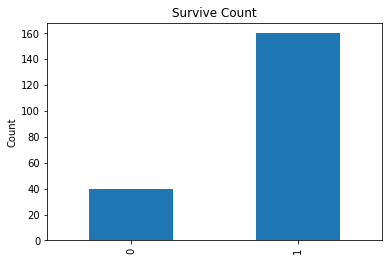

In [14]:
query = 'SELECT COUNT(Survive) AS Survive_Count\
         FROM Icu \
         GROUP BY Survive'
Survive_Count = pd.read_sql(query, conn)
Survive_Count.plot(kind='bar', legend=False, ylabel='Count', title='Survive Count')

We can see that there is an imbalance in the response variable where there are 4 times more patients who survives than those who did not surive, and we can deal with this in a few ways. We can either use resamling techniques, changing weights or leave it as it is and see model performance. For now, I plan to change the weights of given models.

### Age

<AxesSubplot:xlabel='Survive', ylabel='Age'>

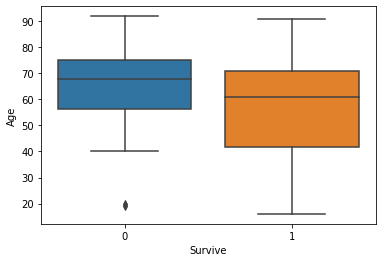

In [15]:
query = 'SELECT Age, Survive\
         FROM Icu'
Age_survive = pd.read_sql(query, conn)
sns.boxplot(data=Age_survive, x='Survive', y='Age')

We can see that those who don't survive are likely to be older. 

<AxesSubplot:xlabel='Age', ylabel='Count'>

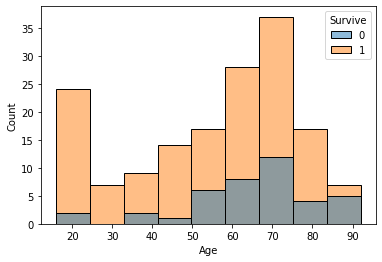

In [16]:
sns.histplot(data=data, x='Age', hue='Survive')

We can also see that for the distribution of the Ages, there are mainly 70 year olds, and the majority of the 20 year olds survive. 

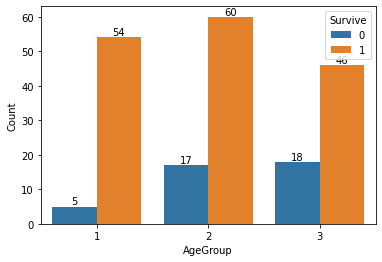

In [17]:
query = 'SELECT Survive, AgeGroup, COUNT(Survive) AS Count\
         FROM Icu \
         GROUP BY AgeGroup, Survive'
gage_survive = pd.read_sql(query, conn)
values = gage_survive.Count.values
ax = sns.barplot(data=gage_survive, x='AgeGroup', y='Count', hue='Survive')
for container in ax.containers:
    ax.bar_label(container)

From the above plot, we can tell that those who fall into the third group for Age, presumably the oldest age range group, has the lowest chance of surviving whereas if you are from group 1, presumably the youngest, you have the highest chance of surviving. 

### Sex

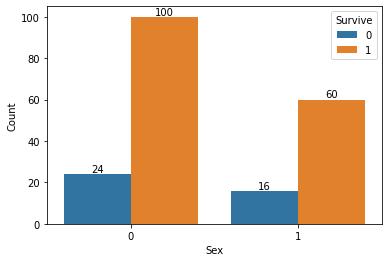

In [18]:
query = 'SELECT Survive, Sex, COUNT(Survive) AS Count\
         FROM Icu \
         GROUP BY Sex, Survive'
sex_survive = pd.read_sql(query, conn)
values = sex_survive.Count.values
ax = sns.barplot(data=sex_survive, x='Sex', y='Count', hue='Survive')
for container in ax.containers:
    ax.bar_label(container)

There is no information given about which value of sex corresponds to male/female so we cannot conclude much using those terms. However, based on the plot, we can see that for those who are of Sex == 1, they have a higher proportion of people who don't survive compared to those who are of Sex==0.

### Infection

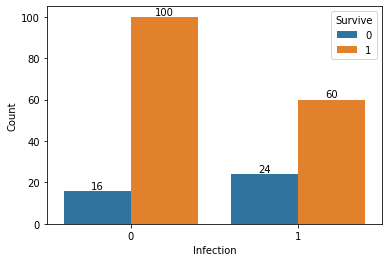

In [19]:
query = 'SELECT Survive, Infection, COUNT(Survive) AS Count\
         FROM Icu \
         GROUP BY Infection, Survive'
infection_survive = pd.read_sql(query, conn)
values = infection_survive.Count.values
ax = sns.barplot(data=infection_survive, x='Infection', y='Count', hue='Survive')
for container in ax.containers:
    ax.bar_label(container)

There is no information given about which value Infection corresponds to, but let us assume Infection == 1 means they have an infection. Based on the plot, we can see that for those who have Infection == 1, they have a higher proportion of people who don't survive compared to those who have Infection == 0.

### Blood Pressure

<AxesSubplot:xlabel='Survive', ylabel='SysBP'>

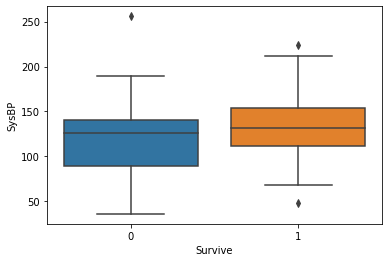

In [20]:
query = 'SELECT SysBP, Survive\
         FROM Icu'
bp_survive = pd.read_sql(query, conn)
sns.boxplot(data=bp_survive, x='Survive', y='SysBP')

For those who tend to not survive, their blood pressure is lower. 

### Pulse

<AxesSubplot:xlabel='Survive', ylabel='Pulse'>

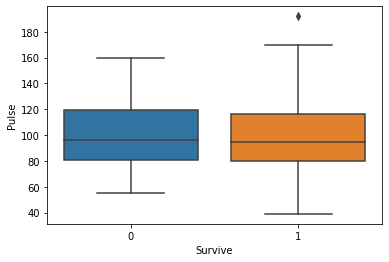

In [21]:
query = 'SELECT Pulse, Survive\
         FROM Icu'
pulse_survive = pd.read_sql(query, conn)
sns.boxplot(data=pulse_survive, x='Survive', y='Pulse')

It seems as though Pulse of a patient does not significantly determine whether a patient survives or not, but maybe one could say based on the Box Plot above, people who don't survive have a slightly higher pulse. 

### Emergency

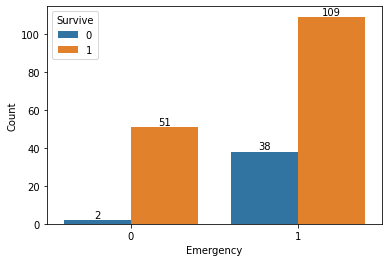

In [22]:
query = 'SELECT Survive, Emergency, COUNT(Survive) AS Count\
         FROM Icu \
         GROUP BY Emergency, Survive'
er_survive = pd.read_sql(query, conn)
values = er_survive.Count.values
ax = sns.barplot(data=er_survive, x='Emergency', y='Count', hue='Survive')
for container in ax.containers:
    ax.bar_label(container)

We can clearly see from the above plot that, for a patient who is admitted to the emergency room, they have a higher chance of surviving.

### Correlation
Let us plot the correlation for between each feature and check for multicollinearity as well as which features are correlated to the response variable, Surviveability. We use the following metrics to measure correlation:
- Pearson (Cont - Cont)
- Cramer v (Cat - Cat)
- Correlation Ratio (Cat - Cont)

In [23]:
cat_lst = ['Survive', 'AgeGroup', 'Sex', 'Infection', 'Emergency']
cat_dict = {}

cont_dict = {}
cont_lst = ['Age', 'SysBP', 'Pulse']

for val in cat_lst:
    cat_dict[val] = 'categorical'

for val in cont_lst:
       cont_dict[val] = 'continuous'

cont_dict.update(cat_dict)
corr_df = data.copy()
corr_df.drop(['ID'], axis=1, inplace=True)
# corr_df[cat_lst] = corr_df[cat_lst].astype('category')

Age,AgeGroup 0.915577261411191


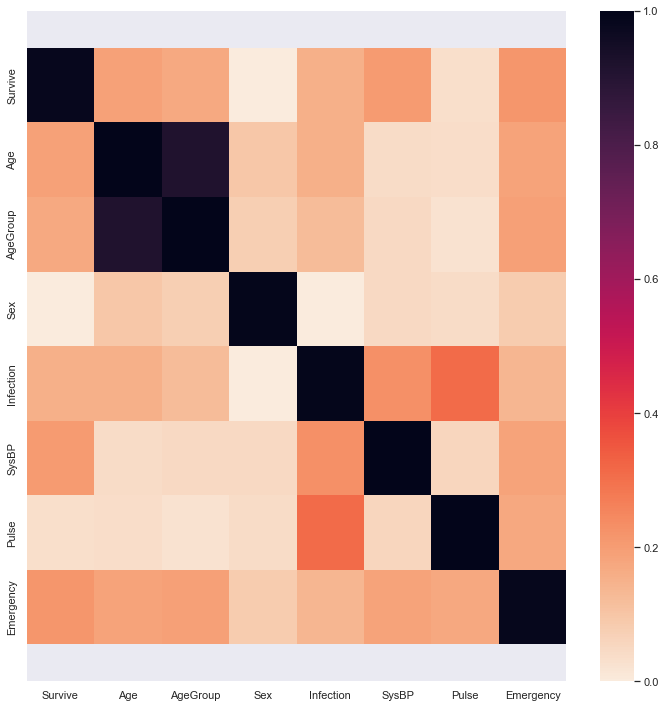

In [24]:
column_names = corr_df.columns.tolist()
corr_dict = cont_dict
corr_lst = []

corr_matrix = np.zeros((len(column_names), len(column_names)))
corr_matrix = pd.DataFrame(corr_matrix, columns = column_names, index = column_names)

def cramers_corrected_stat(x, y): # Correlation between 2 categorical variables
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def correlation_ratio(categories, measurements): # Correlation between categorical and continuous variable
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def correlation_coeff(x, y): # Pearson - Correlation between 2 continuous variables
    abs_corr = abs(x.corr(y, method = 'pearson'))
    return abs_corr

for key in corr_dict:
    for key2 in corr_dict:
        if corr_dict[key] == 'continuous' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_coeff(corr_df[key], corr_df[key2])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'continuous':
            curr_corr = correlation_ratio(corr_df[key], corr_df[key2])
        elif corr_dict[key] == 'continuous' and corr_dict[key2] == 'categorical':
            curr_corr = correlation_ratio(corr_df[key2], corr_df[key])
        elif corr_dict[key] == 'categorical' and corr_dict[key2] == 'categorical':
            curr_corr = cramers_corrected_stat(corr_df[key], corr_df[key2])
        corr_matrix[key][key2] = curr_corr

        if curr_corr >= 0.7 and column_names.index(key) < column_names.index(key2):
            corr_lst.append([key, key2, curr_corr])
            print(key + "," + key2 + " " + str(curr_corr))

sns.set(rc={'figure.figsize':(10,10)})
ax = sns.heatmap(corr_matrix,
                 xticklabels = column_names,
                 yticklabels = column_names,
                 vmin = 0,
                 vmax = 1,
                 cmap = sns.cm.rocket_r)

top, bottom = ax.get_ylim()
ax.set_ylim(top + 0.5, bottom - 0.5)
plt.tight_layout()
plt.show()

From the above plot, we can see that Age and AgeGroup are highly correlated which is not surprising. We may drop one of the columns for the Logistic Regression Model since it is affected by multi-collinearity but leave it in for the Decision Tree and Random Forest since mutlicollinearity does not affect decision trees. Let us drop AgeGroup as it is less correlated to the response variable than Age. 

### Modelling v1 - Train using original data without resampling techniques

- Train Test Split
- Standardize
- Modelling

### Train Test Split
We used Stratified Sampling so as to ensure that the features that have the greatest influence on our response
are equally distributed in the training and testing data set. Doing so would also ensure that both the training and
testing dataset contain the same ratio of classes. Using the StratifiedShuffleSplit class from the sklearn library in
python, we split the original data set into a 80:20 ratio, where 80% of the data set is used for training, and the
rest for testing.

In [25]:
df = data.drop(['ID'], axis=1)
stratified = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_set, test_set in stratified.split(df, df['Survive']):
    stratified_train = df.loc[train_set]
    stratified_test = df.loc[test_set]
    
X_test = stratified_test.loc[:, stratified_test.columns != 'Survive'] # we test on this
y_test = stratified_test.loc[:, 'Survive'] # we test on this
X_train = stratified_train.loc[:, stratified_train.columns != 'Survive'] 
y_train = stratified_train.loc[:, 'Survive']

### Standardize Training Data

In [26]:
scaler = StandardScaler()
trainvalues_to_scale = X_train.select_dtypes(include='number')
testvalues_to_scale = X_test.select_dtypes(include='number')
train_scaled_cols = scaler.fit_transform(trainvalues_to_scale)
test_scaled_cols = scaler.transform(testvalues_to_scale)

X_train['Age'] = train_scaled_cols[:, 0]
X_train['SysBP'] = train_scaled_cols[:, 1]
X_train['Pulse'] = train_scaled_cols[:, 2]

X_test['Age'] = test_scaled_cols[:, 0]
X_test['SysBP'] = test_scaled_cols[:, 1]
X_test['Pulse'] = test_scaled_cols[:, 2]

Xlr_test = X_test.drop(['AgeGroup'], axis=1) # For logistic regression
Xlr_train = X_train.drop(['AgeGroup'], axis=1) # For logistic regression

C:\Users\xyber\AppData\Local\Temp\ipykernel_25468\1896789836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age'] = train_scaled_cols[:, 0]
C:\Users\xyber\AppData\Local\Temp\ipykernel_25468\1896789836.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['SysBP'] = train_scaled_cols[:, 1]
C:\Users\xyber\AppData\Local\Temp\ipykernel_25468\1896789836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

### Hyperparameter Tuning
- We need to reduce the number of False Positives in our dataset, and hence, we shall target our tuning on maximizing our precision score. Precision is given by TP/ (TP+FP). 

In [27]:
## Function for Hyper Parameter Tuning
def hyperparameter_tuning(parameters, model, X_train, y_train, score='precision'):
    best_params = {}
    best_model = GridSearchCV(
        estimator=model, param_grid=parameters, scoring=score, refit=True, cv = 5, n_jobs = -1, verbose=1, return_train_score=True, error_score='raise'
    )
    best_model.fit(X_train, y_train)
    best_params[score] = best_model.best_params_
    return best_params, best_model

In [28]:
## Search Grid
model_dt = DecisionTreeClassifier(random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_lr = LogisticRegression()

tuned_parameters_dt = {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": range(2, 9),
    "min_samples_split": range(2, 10, 2),
    "min_samples_leaf": range(1, 10, 2), 
    "max_features": ["auto", "sqrt", "log2"], 
    "class_weight": ["balanced", {0:4, 1:1}, {0:2, 1:1}, {0:1, 1:1}]
} 
tuned_parameters_rf = { 
    'n_estimators': [3, 4, 5, 6, 20, 50],
    'max_features': ["sqrt", "log2"],
    'max_depth' : [1,2,3,4],
    'criterion' :['gini', 'entropy'], 
    'min_samples_split': [2,3,4], 
    'min_samples_leaf': range(2, 10, 2), 
    'n_jobs': [-1], 
    'class_weight': ["balanced", {0:4, 1:1}, {0:2, 1:1}]
}

tuned_parameters_lr = {
    'penalty': ['l1', 'l2'], 
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear'], 
    'class_weight': ['balanced', {0:4, 1:1}, {0:2, 1:1}, {0:8, 1:1}]
    }

# tuned_parameters_lr = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
# ]


In [29]:
# # As we have already trained the model, please load the model from saved models to save time. If you would like to train the model, uncomment the 3 lines below. 
# dt_params, dt_model1 = hyperparameter_tuning(tuned_parameters_dt, model_dt, X_train, y_train)
# rf_params, rf_model1 = hyperparameter_tuning(tuned_parameters_rf, model_rf, X_train, y_train)
# lr_params, lr_model1 = hyperparameter_tuning(tuned_parameters_lr, model_lr, Xlr_train, y_train)

In [30]:
### Load Best Models
import pickle
rf_model1 = pickle.load(open('../saved_models/rf.pkl', 'rb'))
dt_model1 = pickle.load(open('../saved_models/dt.pkl', 'rb'))
lr_model1 = pickle.load(open('../saved_models/lr.pkl', 'rb'))

We also want to make sure that our model has not overfitted, so we plot the validation and training curves.

In [31]:
dt_params

NameError: name 'dt_params' is not defined

In [ ]:
rf_params

{'precision': {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 5,
  'n_jobs': -1}}

In [ ]:
lr_params

{'precision': {'C': 0.046415888336127774,
  'class_weight': {0: 8, 1: 1},
  'penalty': 'l1',
  'solver': 'liblinear'}}

In [ ]:
def get_curves(model, params, model_name):
    df = pd.DataFrame(model.cv_results_)
    results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    def pooled_var(stds):
        n = 5 # size of each group
        return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


    fig, axes = plt.subplots(1, len(params)-1, 
                            figsize = (5*len(params), 7),
                            sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(params.items()):
        if param_name =='class_weight':
            continue
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': pooled_var,
                'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                    color="darkorange", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                        grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                        color="darkorange", lw=lw)
        axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                    color="navy", lw=lw)
        axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                        color="navy", lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f'{model_name} validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

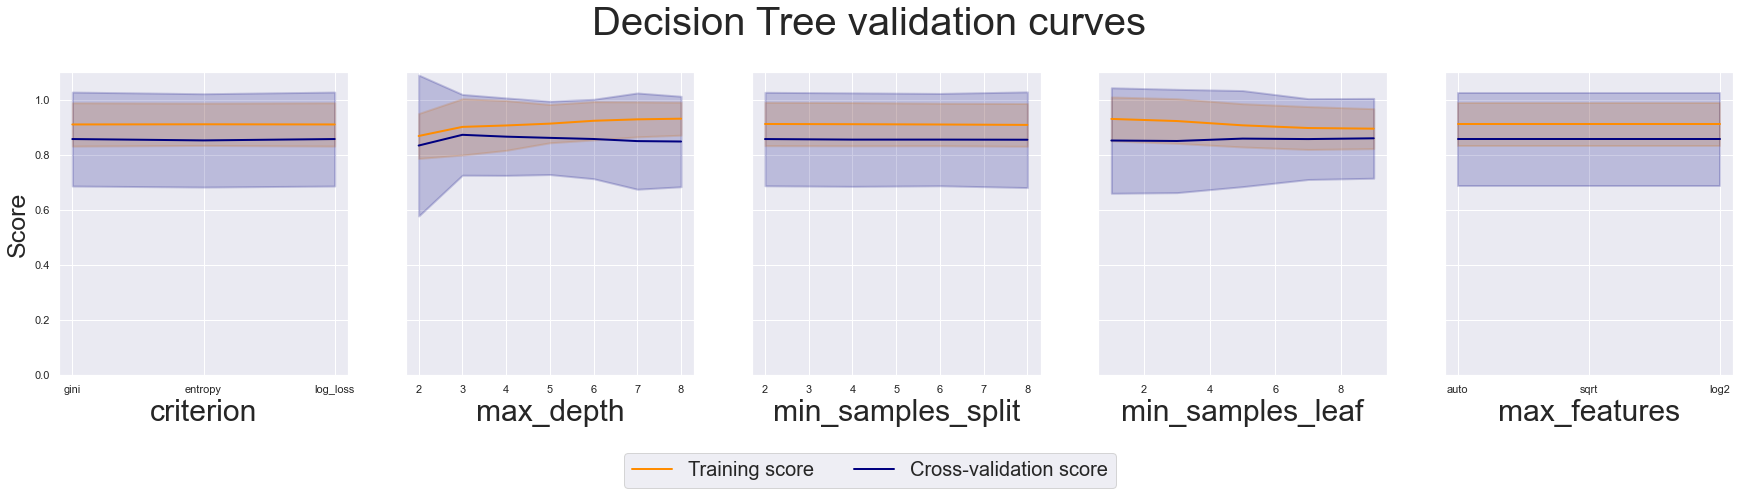

In [ ]:
get_curves(dt_model1, tuned_parameters_dt, 'Decision Tree')

- We can see that for max_depth, the higher the value, the more the overfitting occurs. 

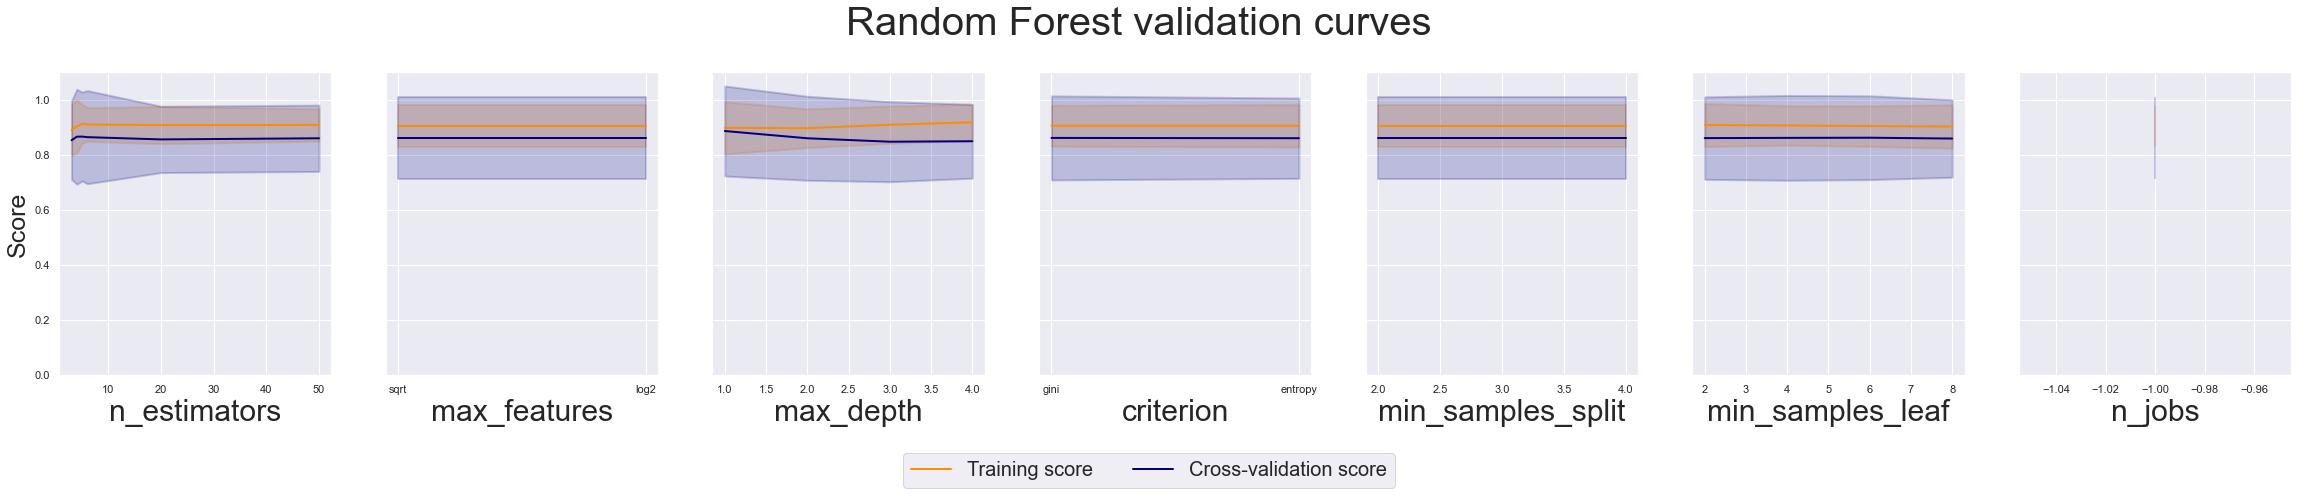

In [ ]:
get_curves(rf_model1, tuned_parameters_rf, 'Random Forest')

Similar to the decision tree, as the max depth value increases, the model starts to overfit. Another thing to note is that the number of estimators , as increased, does not affect the model after a certain threshold of 5. 

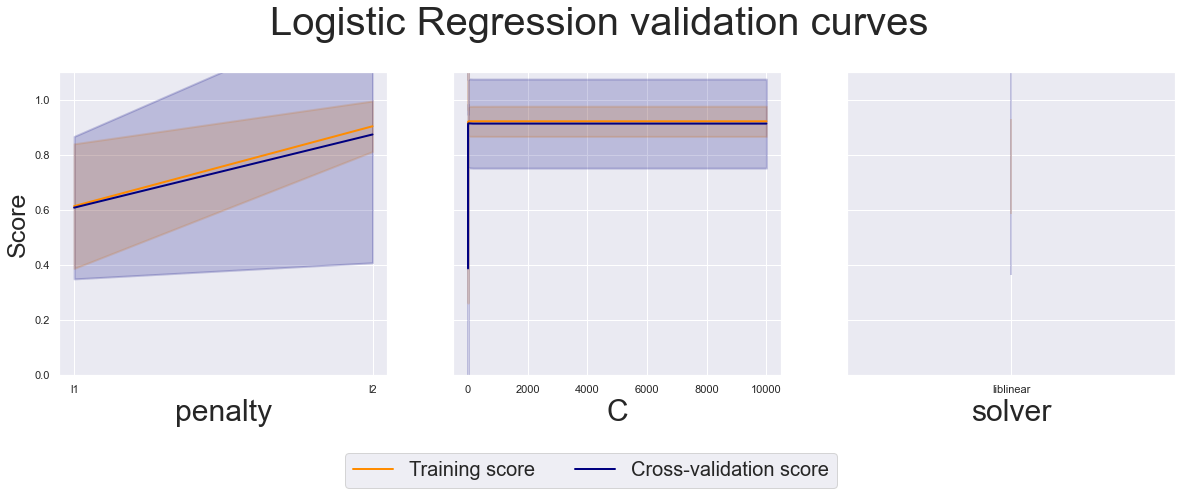

In [ ]:
get_curves(lr_model1, tuned_parameters_lr, 'Logistic Regression')

### Testing

In [ ]:
rf_pred = rf_model1.predict(X_test)
dt_pred = dt_model1.predict(X_test)
lr_pred = lr_model1.predict(Xlr_test)

rf_proba = rf_model1.predict_proba(X_test)[:, 1]
dt_proba = dt_model1.predict_proba(X_test)[:, 1]
lr_proba = lr_model1.predict_proba(Xlr_test)[:, 1]

### Scores
- Precision, Recall, Accuracy, AUCROC, F1, Specificity
- Confusion Matrix
- ROC Curve

In [ ]:
## Function to produce confusion matrix
def cm_matrix(y_pred, y_test):
    cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
    cm.columns = ['True Y = 0', 'True Y = 1']
    cm.index = ['Predicted Y = 0','Predicted Y = 1']
    return cm

## Function to generate AUC ROC Curve
def roc_auc_curve(y_test, fpr, tpr, label):
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label = 1)
    plt.plot(fpr , tpr , linestyle = '--', color = 'orange', label = label)
    plt.plot(p_fpr, p_tpr, linestyle = '--', color = 'blue')
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show()

## Function that consolidates performance metrics of model
def results(y_pred, y_prob, y_test, model_used):
    scores = {}
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['accuracy'] = accuracy_score(y_test, y_pred)
    scores['auc'] = roc_auc_score(y_test, y_prob)
    scores['f1_score'] = f1_score(y_test, y_pred)
    cm = cm_matrix(y_pred, y_test)
    specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
    scores['specificity'] = specificity
    fpr , tpr , threshold = roc_curve(y_test, y_prob)
    print(scores)
    print(cm)
    roc_auc_curve(y_test, fpr, tpr, model_used)
    return scores

## Function to display significance of variables in building of model
def plot_feature_importance(train, model):
    X_train_cols = train.columns
    scores = model.best_estimator_.feature_importances_
    res = {}
    for i in range(len(scores)):
        res[X_train_cols[i]] = scores[i]
    x = list(res.keys())
    y = list(res.values())
    sns.barplot(x=x, y=y)
    plt.title('Feature Importance', fontsize=20)
    plt.ylabel('Score', fontsize = 20)
    plt.xticks(fontsize=16, rotation = 90)
    plt.yticks(fontsize=20)
    plt.show()

#### Decision Tree

{'precision': 0.9444444444444444, 'recall': 0.53125, 'accuracy': 0.6, 'auc': 0.771484375, 'f1_score': 0.6799999999999999, 'specificity': 0.875}
                 True Y = 0  True Y = 1
Predicted Y = 0           7          15
Predicted Y = 1           1          17


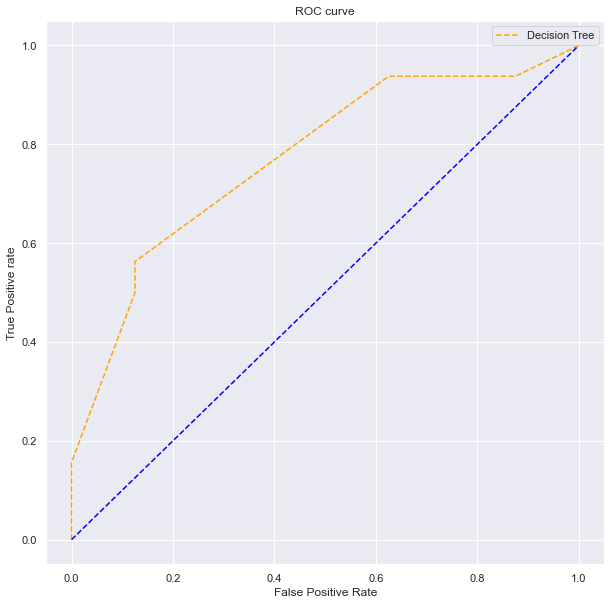

In [ ]:
dt_res = results(dt_pred, dt_proba, y_test, 'Decision Tree')

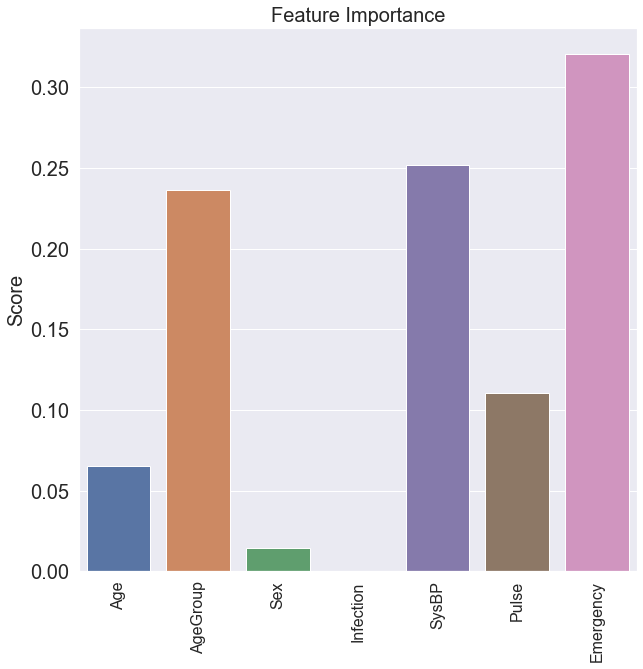

In [ ]:
plot_feature_importance(X_train, dt_model1)

#### Random Forest

{'precision': 0.84375, 'recall': 0.84375, 'accuracy': 0.75, 'auc': 0.736328125, 'f1_score': 0.84375, 'specificity': 0.375}
                 True Y = 0  True Y = 1
Predicted Y = 0           3           5
Predicted Y = 1           5          27


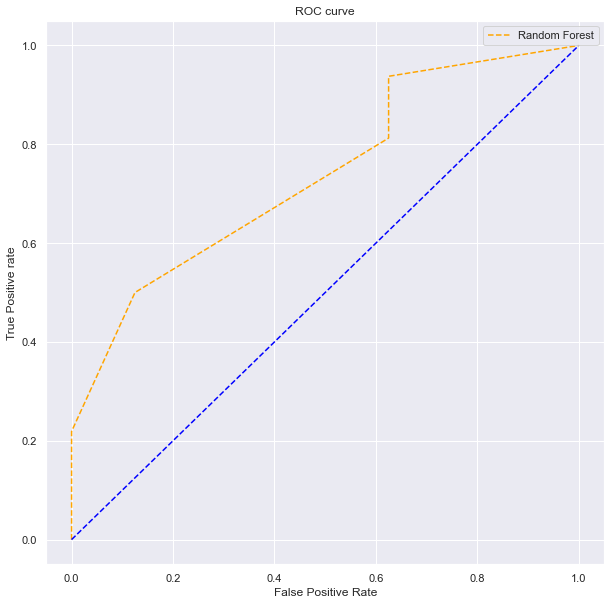

In [ ]:
rf_res = results(rf_pred, rf_proba, y_test, 'Random Forest')

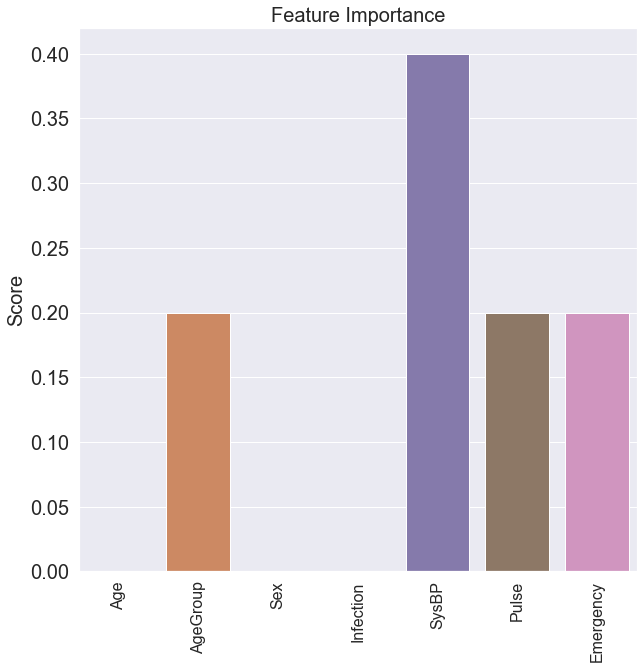

In [ ]:
plot_feature_importance(X_train, rf_model1)

#### Logistic Regression

{'precision': 1.0, 'recall': 0.09375, 'accuracy': 0.275, 'auc': 0.76953125, 'f1_score': 0.17142857142857143, 'specificity': 1.0}
                 True Y = 0  True Y = 1
Predicted Y = 0           8          29
Predicted Y = 1           0           3


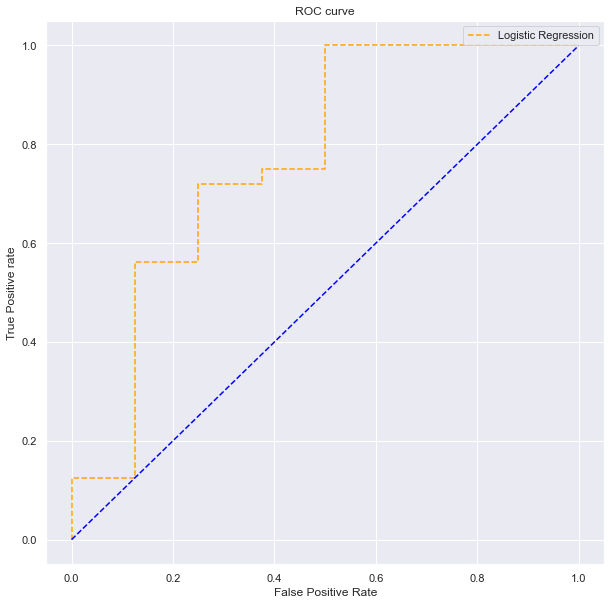

In [ ]:
lr_res = results(lr_pred, lr_proba, y_test, 'Logistic Regression')

In [ ]:
lr_model1.best_estimator_.coef_

array([[-0.30047267,  0.        ,  0.        ,  0.09257882,  0.        ,
        -0.65646986]])

In [ ]:
Xlr_train.columns

Index(['Age', 'Sex', 'Infection', 'SysBP', 'Pulse', 'Emergency'], dtype='object')

Here, we can see how the coefficients of the Logistic Regression model is behaving. For example, the coefficient of Age is -0.3, which tells us that for 1 unit increase in Age, holding all other predictors constant, the log odds of Survive=1 decreases by 0.3. Then, for features Sex, Infection and Pulse, the log odds of Y remains the same regardless of any change in the Predictor, holding all other predictors constant. 

### Full results

<AxesSubplot:ylabel='Score'>

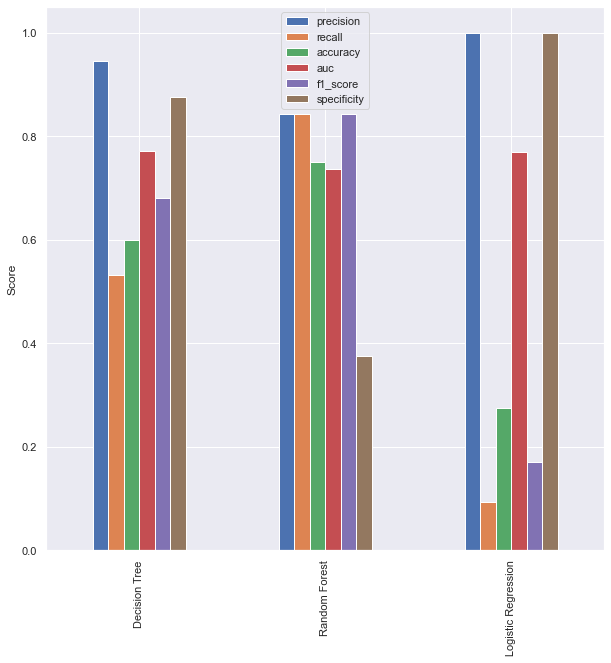

In [ ]:
dt_res = pd.DataFrame(dt_res, index=['Decision Tree'])
rf_res = pd.DataFrame(rf_res, index=['Random Forest'])
lr_res = pd.DataFrame(lr_res, index=['Logistic Regression'])
results = pd.concat([dt_res, rf_res, lr_res], axis=0)
results.plot(kind='bar', ylabel='Score')

### Save Models

In [ ]:
# import pickle
# pickle.dump(dt_model1, open('../saved_models/dt.pkl', 'wb'))
# pickle.dump(rf_model1, open('../saved_models/rf.pkl', 'wb'))
# pickle.dump(lr_model1, open('../saved_models/lr.pkl', 'wb'))

### Discussion

We see that the Random Forest gives us the best all round results and this is to be expected as it an ensemble of the decision tree, whereas for the Decision Tree and Logistic Regression, though the precision values were high, it was traded off with recall. This means that the decision tree and logistic regression are not able to capture the 1's in the surviveability column well. This could mean there is a high bias present. 

The decision tree still outperformed the logistic regression model in most of the metrics except Precision. Perhaps the data is not linearly separable, and hence this causes the Logistic Regression model to perform poorly, whereas for the tree based models, they are non-parametric models and hence are not hindered by non-linear data. 

The decision tree gives the Emergency Column the most importance, followed by SysBP and then AgeGroup. For the random forest, SysBP is given the most importance. Interestingly enough, infection was not given any importance by both models. 

For the logisitc regression model, we have deemed that any change in Age, Sex and Pulse columns do not change the log odds of Surviveability, while holding all other predictors constant. 

### Limitations

One major limitation of the project is the lack of data, as we only have access to 200 total samples. Out of that, 160 rows were used for training. To improve the performance of the models, we need access to more data. 

### Future Works
- Resampling Techniques such as SMOTE and Oversampling<- Need to manually implement Cross Validation if we want to do it. 
- Try Recursive Feature Elimination with Cross Validation to get best features before carrying out modelling. 
- Try more models such as the Naive Bayes Classifier or KNN. 